In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit

from scipy.linalg import expm
from scipy.stats import binom

In [2]:
α = 0.6
λ = 0.5
γ = 0.1
b = 10

In [3]:
@njit
def draw_X(T, X_0, max_iter=5000):
    """
    Generate one draw of X_T given X_0.
    """

    J, Y = 0, X_0
    m = 0

    while m < max_iter:
        s = 1/γ if Y == 0 else 1/λ
        W = np.random.exponential(scale=s)  # W ~ E(λ)
        J += W
        if J >= T:
            return Y
        # Otherwise update Y
        if Y == 0:
            Y = b
        else:
            U = np.random.geometric(α)
            Y = Y - min(Y, U)
        m += 1


@njit
def independent_draws(T=10, num_draws=100):
    "Generate a vector of independent draws of X_T."

    draws = np.empty(num_draws, dtype=np.int64)

    for i in range(num_draws):
        X_0 = np.random.binomial(b+1, 0.25)
        draws[i] = draw_X(T, X_0)

    return draws

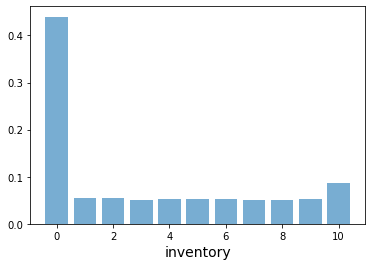

In [4]:
T = 30
n = b + 1 
draws = independent_draws(T, num_draws=100_000)
fig, ax = plt.subplots()

ax.bar(range(n), [np.mean(draws == i) for i in range(n)], width=0.8, alpha=0.6)
ax.set_xlabel("inventory", fontsize=14)

plt.show()

In [5]:
α = 0.6
λ = 0.5
γ = 0.1
b = 10

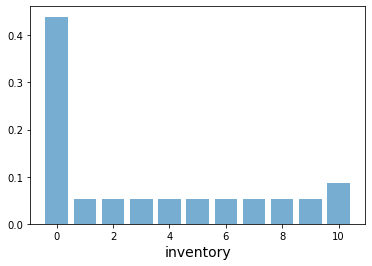

In [6]:
states = np.arange(n)
I = np.identity(n)

# Embedded jump chain matrix
K = np.zeros((n, n))
K[0, -1] = 1
for i in range(1, n):
    for j in range(0, i):
        if j == 0:
            K[i, j] = (1 - α)**(i-1)
        else:
            K[i, j] = α * (1 - α)**(i-j-1)

# Jump intensities as a function of the state
r = np.ones(n) * λ
r[0] = γ

# Q matrix
Q = np.empty_like(K)
for i in range(n):
    for j in range(n):
        Q[i, j] = r[i] * (K[i, j] - I[i, j])

def P_t(ψ, t):
    return ψ @ expm(t * Q)

ψ_0 = binom.pmf(states, n, 0.25)
ψ_T = P_t(ψ_0, T)

fig, ax = plt.subplots()

ax.bar(range(n), ψ_T, width=0.8, alpha=0.6)
ax.set_xlabel("inventory", fontsize=14)

plt.show()